In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
# Import necessary libraries and make necessary arrangements
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost 
import lightgbm as lgb
import warnings
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:

# Date Features
def create_date_features(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    #df["is_wknd"] = df.Date.dt.weekday // 4
    #df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    #df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df

# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=2.0, size=(len(dataframe),))

# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        

In [4]:
df_train=pd.read_csv("../input/store-sales-time-series-forecasting/train.csv",index_col=0)
df_test =pd.read_csv("../input/store-sales-time-series-forecasting/test.csv",index_col=0)
df_transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv")
df_stores = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
df_holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")


df_oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
df_oil['date'] = df_oil['date'].astype("datetime64")
df_date = pd.DataFrame(pd.date_range("2013-01-01","2017-08-31"),columns=["date"])
df_oil = df_date.merge(df_oil,left_on='date',right_on='date',how='left').fillna(method='ffill').fillna(method='bfill')

In [5]:
df_all = df_train.append(df_test)
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")
df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")
df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],right_on=["date","store_nbr"],how="left")
df_all["date"] = df_all["date"].astype("datetime64")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace(",","_",regex=True)
df_all = df_all.rename(columns = {"date":"Date"})

In [6]:
df_all["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR_WINE_BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [7]:
df_all.columns

Index(['Date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'Holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'transactions', 'dcoilwtico'], dtype='object')

In [8]:
df_all["description"].nunique(),df_all["transferred"].nunique()

(101, 2)

In [9]:
df_all[(df_all["store_nbr"]==9) & (df_all["family"]=="AUTOMOTIVE")].tail(10)

,Date,store_nbr,family,sales,onpromotion,city,state,type,cluster,Holiday_type,locale,locale_name,description,transferred,transactions,dcoilwtico
3066789,2017-08-22,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,47.65
3068571,2017-08-23,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,48.45
3070353,2017-08-24,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,Holiday,Local,Ambato,Fundacion de Ambato,False,NaN,47.24
3072135,2017-08-25,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,47.65
3073917,2017-08-26,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,47.65
3075699,2017-08-27,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,47.65
3077481,2017-08-28,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,46.40
3079263,2017-08-29,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,46.46
3081045,2017-08-30,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,45.96
3082827,2017-08-31,9,AUTOMOTIVE,NaN,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN,NaN,47.26


In [10]:
col = ['Date',
       'store_nbr', 
       'family', 
       'sales', 
       'onpromotion', 
       #'city', 
       #'state',
       #'type', 
       'cluster', 
       'Holiday_type', 
       'locale', 
       #'locale_name',
       'description', 
       'transferred',
       'dcoilwtico'
      ]
df = df_all[col]

In [11]:
df.head()

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14


In [12]:
df["store_nbr"].nunique(),df["family"].nunique()

(54, 33)

In [13]:
df.loc[:,"store_nbr"] = df["store_nbr"].astype("category")
df.loc[:,"family"] = df["family"].astype("category")
df.loc[:,"onpromotion"] = df["onpromotion"].astype("int64")
#df.loc[:,"city"] = df["city"].astype("category")
#df.loc[:,"state"] = df["state"].astype("category")
#df.loc[:,"type"] = df["type"].astype("category")
df.loc[:,"Holiday_type"] = df["Holiday_type"].astype("category")
df.loc[:,"locale"] = df["locale"].astype("category")
#df.loc[:,"locale_name"] = df["locale_name"].astype("category")
df.loc[:,"description"] = df["description"].astype("category")
df.loc[:,"transferred"] = df["transferred"].astype("category")

In [14]:
zero_index = df.groupby(["store_nbr","family"]).sum()[df.groupby(["store_nbr","family"]).sum()["sales"]==0].index

## Data Engineering

In [15]:
df = create_date_features(df)
df = lag_features(df, lags = [16,17,18,19,20,21,22,30,31,90,180,365])
df = roll_mean_features(df,[16,17,18,30])

alphas = [0.95,0.9, 0.8, 0.5]
lags =[1, 7,30]
df = ewm_features(df, alphas, lags)

df['sales'] = np.log1p(df["sales"].values)

In [16]:
df_all["family"]=df_all["family"].astype("category")
df_all["store_nbr"]=df_all["store_nbr"].astype("category")
df_all["city"]=df_all["city"].astype("category")
df_all["state"]=df_all["state"].astype("category")
df_all["type"]=df_all["type"].astype("category")

## Train Test Split

In [17]:
df= df[df["Date"]>"2013-12-31"]

val = df[(df["Date"]>"2017-08-01")&(df["Date"]<="2017-08-15")]
train  = df[df["Date"]<="2017-08-01"]
test = df[df["Date"]>"2017-08-15"]

col_X = [col for col in train.columns if col not in ['Date', 'sales','year']]

y_train = train["sales"]
y_val = val["sales"]
X_train = train[col_X]
X_val = val[col_X]
X_test = test[col_X]
y_test = test["sales"]

## Train Model

In [18]:
# LightGBM parameters
lgb_params = {'metric': {'mse'},
              'boosting_type' : 'gbdt',
              'num_leaves': 8,
              'learning_rate': 0.2,
              #'feature_fraction': 0.8,
              'max_depth': 7,
              'verbose': 0,
              'num_boost_round': 5000,
              'early_stopping_rounds': 200,
              'nthread': -1,
             'force_col_wise':True}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=col_X)
lgbtest = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=col_X)

#del Y_train, X_train, Y_test,X_test

In [19]:
from sklearn.metrics import mean_absolute_error
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  #feval=mean_absolute_error,
                  verbose_eval=100,
                  )

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.177767	valid_1's l2: 0.168186
[200]	training's l2: 0.165642	valid_1's l2: 0.159789
[300]	training's l2: 0.158563	valid_1's l2: 0.155648
[400]	training's l2: 0.154282	valid_1's l2: 0.152916
[500]	training's l2: 0.150231	valid_1's l2: 0.149829
[600]	training's l2: 0.147861	valid_1's l2: 0.14796
[700]	training's l2: 0.145624	valid_1's l2: 0.146951
[800]	training's l2: 0.143827	valid_1's l2: 0.146022
[900]	training's l2: 0.142485	valid_1's l2: 0.144837
[1000]	training's l2: 0.141226	valid_1's l2: 0.144082
[1100]	training's l2: 0.140015	valid_1's l2: 0.143687
[1200]	training's l2: 0.13877	valid_1's l2: 0.143153
[1300]	training's l2: 0.137962	valid_1's l2: 0.142741
[1400]	training's l2: 0.136737	valid_1's l2: 0.142342
[1500]	training's l2: 0.135889	valid_1's l2: 0.142198
[1600]	training's l2: 0.135146	valid_1's l2: 0.141953
[1700]	training's l2: 0.134452	valid_1's l2: 0.141804
[1800]	training's l2: 0.133667	

In [20]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [21]:
from sklearn.metrics import mean_squared_log_error

In [22]:
y_pred_val[y_pred_val<0]=0

In [23]:
mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))

0.14000961270414392

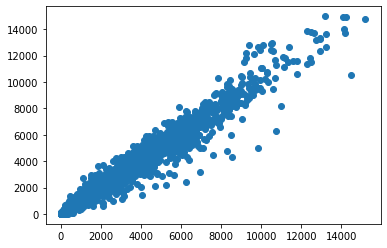

In [24]:
plt.scatter(np.expm1(y_val),np.expm1(y_pred_val))

In [25]:
model.feature_importance()

array([4183, 3395,  356,   54,   32,   49, 3276,   25,  754,  100,  621,
        698,  245, 1030,  220,  176,  168,  216,  176,  488,  192,   85,
        139,  187,  269,  157,  103,  102,   98,  306,  928,  699,   88,
        368,  315,   62,  672,  367,   58, 1303,  531,  180], dtype=int32)

In [26]:
model.feature_name()

['store_nbr',
 'family',
 'onpromotion',
 'cluster',
 'Holiday_type',
 'locale',
 'description',
 'transferred',
 'dcoilwtico',
 'month',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'day_of_week',
 'sales_lag_16',
 'sales_lag_17',
 'sales_lag_18',
 'sales_lag_19',
 'sales_lag_20',
 'sales_lag_21',
 'sales_lag_22',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_90',
 'sales_lag_180',
 'sales_lag_365',
 'sales_roll_mean_16',
 'sales_roll_mean_17',
 'sales_roll_mean_18',
 'sales_roll_mean_30',
 'sales_ewm_alpha_095_lag_1',
 'sales_ewm_alpha_095_lag_7',
 'sales_ewm_alpha_095_lag_30',
 'sales_ewm_alpha_09_lag_1',
 'sales_ewm_alpha_09_lag_7',
 'sales_ewm_alpha_09_lag_30',
 'sales_ewm_alpha_08_lag_1',
 'sales_ewm_alpha_08_lag_7',
 'sales_ewm_alpha_08_lag_30',
 'sales_ewm_alpha_05_lag_1',
 'sales_ewm_alpha_05_lag_7',
 'sales_ewm_alpha_05_lag_30']

## Submission

In [27]:
submission = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")
y_test = model.predict(X_test, num_iteration=model.best_iteration)

In [28]:
y_test[y_test<0]=0

In [29]:
submission["sales"] = np.expm1(y_test)

In [30]:
submission.to_csv("submission.csv",index=False)

In [31]:
submission

,id,sales
0,3000888,4.139020
1,3000889,0.005699
2,3000890,5.741029
3,3000891,2495.947338
4,3000892,0.059670
...,...,...
28507,3029395,392.123354
28508,3029396,128.706923
28509,3029397,1687.209387
28510,3029398,148.359167
